In [1]:
cd ../src

/home/3005019/ebm_proteins/src


# Create list of all possible combinations

In [2]:
from itertools import chain, combinations, permutations

def get_combinations(iterable):
    s = list(iterable)
    return chain.from_iterable(permutations(s, r) for r in range(3, 4))

In [3]:
codes = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

In [4]:
import numpy as np

In [5]:
codes = np.array([list(i*3) for i in codes]).reshape(63).tolist()

In [6]:
codes = "".join(codes)

In [7]:
codes

'---AAACCCDDDEEEFFFGGGHHHIIIKKKLLLMMMNNNPPPQQQRRRSSSTTTVVVWWWYYY'

In [8]:
seqs = list(set(map(''.join, get_combinations(codes))))

In [9]:
len(seqs) == 21 ** 3

True

# Build MLP

In [12]:
from modeling.mlp import encoding, mlp

2020-04-11 15:49:28,657 - matplotlib.pyplot - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [13]:
import torch

In [15]:
input_size, hidden_size, output_size = 3 * 21, 100, 1

model = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, output_size)
)

In [102]:
import torch

In [44]:
energies = [model(encoding(seq)) for seq in seqs]

In [60]:
import math

In [65]:
boltzmann_factors = [math.exp(-en) for en in energies]

In [67]:
Z = sum(boltzmann_factors)

In [81]:
probas = [factor / Z for factor in boltzmann_factors]

# Store probabilities in a pandas DataFrame

In [80]:
import pandas as pd

In [122]:
probas_df = pd.DataFrame({
    "sequence": seqs,
    "p": probas
})

In [129]:
probas_df.sort_values("p", ascending=False)

,sequence,p
1892,YDF,0.000126
8092,ECH,0.000126
8547,YDH,0.000125
2443,YCH,0.000124
1418,YLF,0.000124
...,...,...
1059,AFC,0.000092
7121,HFA,0.000091
603,A-A,0.000091
5428,AFN,0.000091


# MCMC Simulation

In [130]:
amino_acids = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

In [131]:
gen_seqs = []

In [132]:
from tqdm import tqdm

In [133]:
from copy import copy

In [134]:
old_seq = seqs[np.random.randint(0, len(seqs))]
encoded_old = encoding(old_seq)
old_E = model(encoded_old)

for step in tqdm(range(6000000)):
    # Sample a random position `i` and a random amino acid `a`
    aa_subset = copy(amino_acids)
    i = np.random.randint(0, len(old_seq))
    aa_subset.remove((old_seq[i]))
    a = np.random.choice(aa_subset)

    # Generate new sequence
    new_seq = copy(old_seq)
    new_seq = list(new_seq)
    new_seq[i] = a
    new_seq = "".join(new_seq)

    # Calculate energy of old and new sequences
    encoded_new = encoding(new_seq)
    new_E = model(encoded_new)

    # Accept with probability exp{-(energy_difference)}
    p = math.exp(old_E - new_E)
    u = np.random.uniform()

    if u < p:
        old_seq, old_E, encoded_old = copy(new_seq), copy(new_E), copy(encoded_new)
        gen_seqs.append(old_seq)

100%|██████████| 6000000/6000000 [21:22<00:00, 4676.81it/s]


# Store results of the simulation in a pandas DataFrame

In [191]:
d = pd.DataFrame({
    "index": [i for i in range(len(gen_seqs))],
    "sequences": gen_seqs
})

In [192]:
d = d.groupby("sequences").count().sort_values("index", ascending=False)

In [194]:
d["p"] = d["index"] / d["index"].sum()

In [195]:
d.drop("index", axis=1, inplace=True)

In [197]:
#probas_df.set_index("sequence", inplace=True)

In [198]:
probas_df

,p
sequence,
-MG,0.000107
WFL,0.000099
STG,0.000108
MQW,0.000099
TMS,0.000110
...,...
PPM,0.000106
WKS,0.000105
VFE,0.000104


In [199]:
d.columns = ["p_mcmc"]

In [200]:
d

,p_mcmc
sequences,
ECH,0.000135
LRF,0.000135
TDF,0.000130
EEH,0.000129
ERH,0.000129
...,...
A-M,0.000088
AGQ,0.000088
FFA,0.000087


# Join and plot

In [201]:
df = probas_df.join(d)

In [202]:
df = df.sort_values("p", ascending=False)

In [209]:
df

,p,p_mcmc
sequence,,
YDF,0.000126,0.000125
ECH,0.000126,0.000135
YDH,0.000125,0.000124
YCH,0.000124,0.000118
YLF,0.000124,0.000106
...,...,...
AFC,0.000092,0.000096
HFA,0.000091,0.000093
A-A,0.000091,0.000092


In [213]:
import seaborn as sns
sns.set()

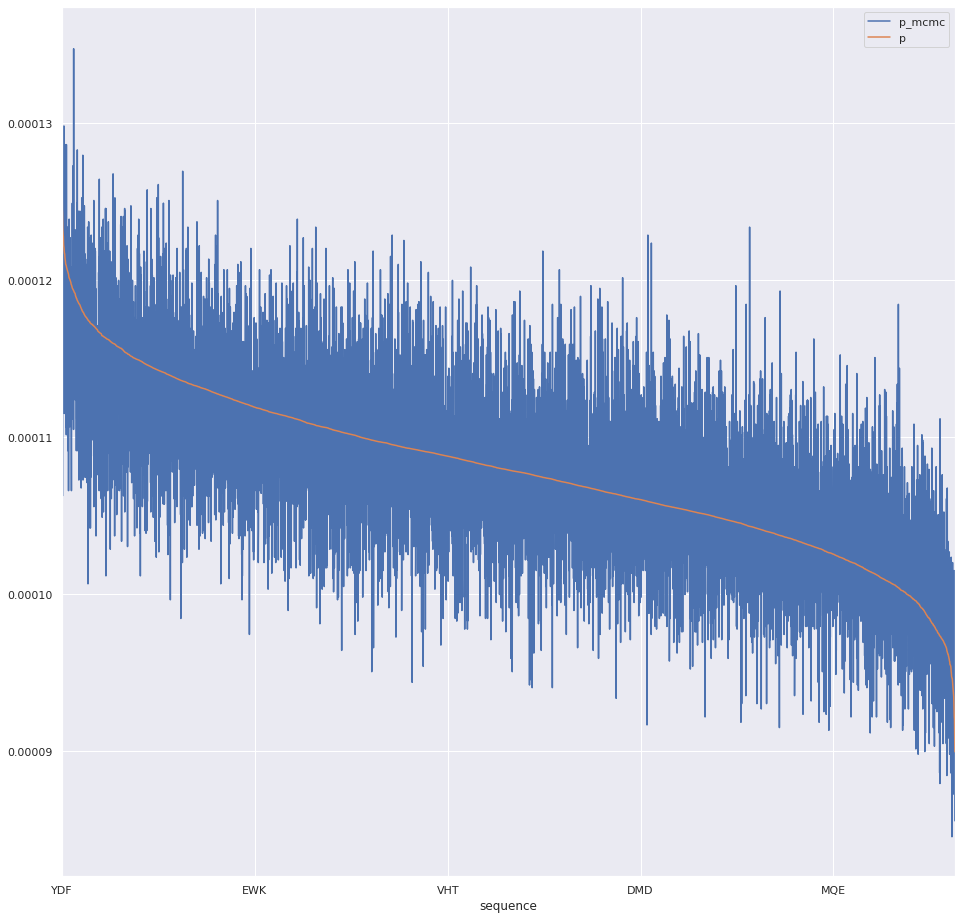

In [217]:
df[["p_mcmc", "p"]].plot(figsize=(16, 16));